# Dataset Analysis with Configurable Train / Val / Test Split

In [46]:
# ------------------------------------------------------------
# CONFIG – edit only the variables below
# ------------------------------------------------------------
TRAIN_DATASETS      = ['camcan', 'dallas_lifespan', 'npc', 'nimh_rv', 'oasis3']  # example
TEST_DATASETS       = ['ixi', 'boldvar']                    # example

VAL_FRACTION        = 0.10   # 0.10 → 10 % of TRAIN becomes VAL
RANDOM_STATE        = 42     # reproducible shuffles
DROP_OTHER_DATASETS = True   # ignore rows from datasets not listed

# --- global analysis parameters -------------------------------------------
AGE_MIN, AGE_MAX = 18, 85
MODALITIES       = ['t1', 't2', 'flair']

# --- minimal subset parameters (hyper-parameter tuning) -------------------
SUBSET_SEX            = 'male'   # 'male' or 'female'
SUBSET_MODALITY       = 't1'     # any value from MODALITIES
SUBSET_AGE_MIN, SUBSET_AGE_MAX = 30, 40  # inclusive range


In [47]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import itertools, warnings, uuid, sys
from sklearn.model_selection import train_test_split
from pathlib import Path
import os

warnings.filterwarnings('ignore')
sns.set(style='whitegrid', context='notebook')

# define labels directory as a sibling to this script's dir
LABEL_DIR = Path('..') / 'labels'
LABEL_DIR.mkdir(parents=True, exist_ok=True)

In [48]:
# ------------------------------------------------------------
# Helper functions
# ------------------------------------------------------------
def clean_df(raw: pd.DataFrame) -> pd.DataFrame:
    """Standardise column names & values, drop unusable rows."""
    df = raw.copy()
    df.columns = df.columns.str.strip().str.lower()

    df['age'] = pd.to_numeric(df['age'], errors='coerce').round(2).astype(float)
    df['sex'] = (df['sex'].astype(str).str.lower().str.strip()
                   .map({'m':'male','male':'male','1':'male',
                        'f':'female','female':'female','2':'female'}))
    df['modality'] = (df['modality'].astype(str).str.lower()
                        .str.extract('(t1|t2|flair)', expand=False))

    df = (df.dropna(subset=['age','sex','modality'])
            .query('@AGE_MIN <= age <= @AGE_MAX'))
    return df

def coverage_report(df: pd.DataFrame, title: str = ''):
    """Report coverage of all (age_bin, sex, modality) combos."""
    df2 = df.copy()
    # integer age bins
    df2['age_bin'] = df2['age'].astype(int)
    # expected combinations
    all_combos = set(itertools.product(range(AGE_MIN, AGE_MAX+1), ['male','female'], MODALITIES))
    # observed combinations
    present = set(zip(df2['age_bin'], df2['sex'], df2['modality']))
    missing = sorted(all_combos - present)
    print(f'=== {title or "Dataset"} ===')
    print(f'Expected combinations : {len(all_combos)}')
    print(f'Observed combinations : {len(present)}')
    print(f'Missing combinations  : {len(missing)}\n')
    if missing:
        display(pd.DataFrame(missing, columns=['age','sex','modality']))
    # one sample per combo
    subset = (df2.groupby(['age_bin','sex','modality'], group_keys=False)
                   .sample(n=1, random_state=42)
                   .reset_index(drop=True))
    subset = subset.drop(columns=['age_bin'])
    return subset

def quick_plots(df: pd.DataFrame, title: str = ''):
    print(f'\n### {title} – shape: {df.shape}\n')
    display(df.head())
    fig, axes = plt.subplots(1, 3, figsize=(18,4))
    sns.countplot(x='modality', data=df, ax=axes[0]); axes[0].set_title('Modality')
    sns.countplot(x='sex',      data=df, ax=axes[1]); axes[1].set_title('Sex')
    sns.histplot(df['age'], bins=20, kde=True, ax=axes[2]); axes[2].set_title('Age')
    plt.suptitle(title); plt.tight_layout(); plt.show()
    for col in ['modality', 'sex']:
        g = sns.catplot(data=df, x=col, col='dataset', kind='count', col_wrap=4, sharey=False)
        g.fig.suptitle(f'{col.capitalize()} distribution per dataset', y=1.02)
        plt.show()
    g = sns.displot(data=df, x='age', col='dataset', bins=20, col_wrap=4, kde=True)
    g.fig.suptitle('Age distribution per dataset', y=1.02)
    plt.show()

In [49]:
# ----------------- Missing-data & count heat-map helpers -----------------
import numpy as np, matplotlib.pyplot as plt, seaborn as sns

def plot_missing_matrix(df: pd.DataFrame,
                        title: str = '',
                        *, group_by=1,
                        save_as: str | None = None,
                        cmap: str = 'binary'):
    """
    Visualise coverage as a white/black matrix.
    """

    ages   = list(range(AGE_MIN, AGE_MAX + 1, group_by))
    combos = [(m, s) for m in MODALITIES for s in ['male', 'female']]
    mat    = np.ones((len(combos), len(ages)), dtype=int)

    present = set(zip(df['age'], df['sex'], df['modality']))

    for r, (mod, sex) in enumerate(combos):
        for c, age in enumerate(ages):
            if all((a, sex, mod) not in present
                   for a in range(age, min(age + group_by, AGE_MAX + 1))):
                mat[r, c] = 0

    fig_h = max(3, 0.6 * len(combos))
    plt.figure(figsize=(18, fig_h))
    sns.heatmap(mat,
                cmap=cmap,
                cbar=False,
                xticklabels=ages,
                yticklabels=[f'{m.upper()} – {sex.capitalize()}' for m, sex in combos])

    plt.title(f'{title}\nblack = present, white = missing', fontsize=14)
    plt.xlabel('Age')
    plt.ylabel('Modality / Sex')
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0)
    plt.tight_layout()

    if save_as:
        plt.savefig(save_as, dpi=150)
    plt.show()

def plot_count_heatmap(df: pd.DataFrame,
                       title: str = '',
                       *,
                       group_by: int = 1,        # age bin width (years)
                       cmap: str   = 'YlGnBu',
                       log_scale: bool = False,
                       save_as: str | None = None):
    

    needed = {'age', 'sex', 'modality'}
    if not needed.issubset(df.columns):
        raise ValueError(f'DataFrame must contain {needed}')

    present = df.copy()
    present['age_bin'] = (present['age'] // group_by) * group_by
    ages   = list(range(AGE_MIN, AGE_MAX + 1, group_by))
    combos = [(m, s) for m in MODALITIES for s in ['male', 'female']]

    mat = np.zeros((len(combos), len(ages)), dtype=int)
    for r, (mod, sex) in enumerate(combos):
        sub = present[(present['modality'] == mod) & (present['sex'] == sex)]
        counts = sub.groupby('age_bin').size()
        for c, age in enumerate(ages):
            mat[r, c] = counts.get(age, 0)

    plot_mat = np.log1p(mat) if log_scale else mat
    cbar_lbl = 'logₑ(1 + count)' if log_scale else 'count'

    fig_h = max(3, 0.6 * len(combos))
    plt.figure(figsize=(18, fig_h))
    sns.heatmap(plot_mat,
                cmap=cmap,
                annot=True,
                fmt='.0f',
                linewidths=.5,
                cbar_kws={'label': cbar_lbl},
                xticklabels=ages,
                yticklabels=[f'{m.upper()} – {s.capitalize()}' for m, s in combos])

    plt.title(f'{title}\\ncell value = number of images', fontsize=14)
    plt.xlabel('Age')
    plt.ylabel('Modality / Sex')
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0)
    plt.tight_layout()

    if save_as:
        plt.savefig(save_as, dpi=150)
    plt.show()

In [50]:
# ------------------------------------------------------------
# Load Excel and concatenate all sheets
# ------------------------------------------------------------
EXCEL_FILE = 'all_datasets_converted.xlsx'  # change path if needed

sheets = pd.read_excel(EXCEL_FILE, sheet_name=None)
df_list = []
for name, sheet in sheets.items():
    if 'dataset' not in sheet.columns or sheet['dataset'].isna().all():
        sheet['dataset'] = name
    df_list.append(sheet)

df_all = pd.concat(df_list, ignore_index=True)
df_all = clean_df(df_all)
print('Loaded & cleaned data →', df_all.shape)

Loaded & cleaned data → (7065, 6)


In [51]:
nimhrv_filenames = [r"*HighResHippo*"]  # Regex for substring match

oasis_filenames = [
    r"*sub-OAS31103_ses-d0170_run-01_T1w*",
    r"*sub-OAS30516_ses-d0225_run-01_T1w*",
    r"*sub-OAS30062_ses-d0087_run-01_T1w*",
    r"*sub-OAS30558_ses-d0061_run-01_T1w*",
    r"*sub-OAS30472_ses-d0058_run-01_T1w*",
    r"*sub-OAS30106_ses-d2982_run-01_T1w*",
    r"*sub-OAS30803_ses-d0086_run-01_T1w*",
    r"*sub-OAS30367_ses-d0055_run-01_T1w*",
    r"*sub-OAS30660_ses-d0087_run-01_T1w*",
    r"*sub-OAS30032_ses-d0262_run-01_T1w*",
    r"*sub-OAS30444_ses-d0001_run-04_T1w*",
    r"*sub-OAS30059_ses-d0230_run-01_T1w*",
    r"*sub-OAS30455_ses-d0171_run-01_T1w*",
    r"*sub-OAS30969_ses-d3306_run-01_T1w*",
    r"*sub-OAS30103_ses-d3306_run-01_T1w*",
    r"*sub-OAS31072_ses-d0833_run-01_T1w*",
    r"*sub-OAS30059_ses-d0230_run-04_T1w*",
    r"*sub-OAS30444_ses-d0001_run-01_T1w*",
    r"*sub-OAS30297_ses-d0105_run-01_T1w*",
    r"*sub-OAS30689_ses-d0282_run-01_T1w*",
    r"*sub-OAS30181_ses-d0129_run-01_T1w*",
    r"*sub-OAS30785_ses-d0768_run-01_T1w*",
    r"*sub-OAS30365_ses-d5600_run-01_T1w*",
    r"*sub-OAS30558_ses-d0155_run-01_T1w*",
    r"*sub-OAS30059_ses-d0230_run-01_T1w*",
    r"*sub-OAS30459_ses-d0078_run-01_T1w*"  # .nii.gz or any suffix
]

REMOVE_PATTERNS = oasis_filenames + nimhrv_filenames

In [52]:
# ------------------------------------------------------------
# Remove images with certain names or patterns
# ------------------------------------------------------------
import fnmatch

# Determine which column to use for filtering
col = 'image_path'
print("DataFrame columns:", df_all.columns)
print("\nSample filenames:")
if 'image_path' in df_all.columns:
    print(df_all['image_path'].head())
print("\nDataFrame shape before removal:", df_all.shape)

if col:
    mask = df_all[col].astype(str).apply(
        lambda x: any(fnmatch.fnmatch(x, p) for p in REMOVE_PATTERNS)
    )
else:
    mask = pd.Series(False, index=df_all.index)

if mask.any():
    print(f"Removing {mask.sum()} rows matching patterns: {REMOVE_PATTERNS}")
    df_all = df_all.loc[~mask].copy()
else:
    print('No rows removed; no filename or image_name patterns matched.')


DataFrame columns: Index(['subject_id', 'image_path', 'sex', 'age', 'modality', 'dataset'], dtype='object')

Sample filenames:
0    brain_age_converted/IXI/IXI002-Guys-0828-T1.ni...
1    brain_age_converted/IXI/IXI002-Guys-0828-T2.ni...
2    brain_age_converted/IXI/IXI012-HH-1211-T1.nii.npy
3    brain_age_converted/IXI/IXI012-HH-1211-T2.nii.npy
4    brain_age_converted/IXI/IXI013-HH-1212-T1.nii.npy
Name: image_path, dtype: object

DataFrame shape before removal: (7065, 6)
Removing 21 rows matching patterns: ['*sub-OAS31103_ses-d0170_run-01_T1w*', '*sub-OAS30516_ses-d0225_run-01_T1w*', '*sub-OAS30062_ses-d0087_run-01_T1w*', '*sub-OAS30558_ses-d0061_run-01_T1w*', '*sub-OAS30472_ses-d0058_run-01_T1w*', '*sub-OAS30106_ses-d2982_run-01_T1w*', '*sub-OAS30803_ses-d0086_run-01_T1w*', '*sub-OAS30367_ses-d0055_run-01_T1w*', '*sub-OAS30660_ses-d0087_run-01_T1w*', '*sub-OAS30032_ses-d0262_run-01_T1w*', '*sub-OAS30444_ses-d0001_run-04_T1w*', '*sub-OAS30059_ses-d0230_run-01_T1w*', '*sub-OAS30455_ses

### Train / Val / Test Split Summary

In [53]:
# ------------------------------------------------------------
# Build explicit TRAIN / VAL / TEST partitions
# ------------------------------------------------------------
train_lower = [d.lower() for d in TRAIN_DATASETS]
test_lower  = [d.lower() for d in TEST_DATASETS]

if set(train_lower) & set(test_lower):
    raise ValueError('A dataset appears in both TRAIN_DATASETS and TEST_DATASETS')

all_datasets_lower = df_all['dataset'].str.lower()
is_train = all_datasets_lower.isin(train_lower)
is_test  = all_datasets_lower.isin(test_lower)

if DROP_OTHER_DATASETS:
    used_mask = is_train | is_test
    dropped   = df_all.loc[~used_mask, 'dataset'].unique()
    if len(dropped):
        print(' ⚠️  Dropping datasets (not in either list):', dropped)
    df_all   = df_all[used_mask].copy()
    is_train = is_train.loc[df_all.index]
    is_test  = is_test .loc[df_all.index]

# ---------- split ----------------------------------------------------------
df_train_full = df_all[is_train].copy()
df_test       = df_all[is_test ].copy()

if VAL_FRACTION > 0 and not df_train_full.empty:
    df_train, df_val = train_test_split(
        df_train_full,
        test_size   = VAL_FRACTION,
        random_state= RANDOM_STATE,
        stratify    = df_train_full[['modality','sex']]
    )
else:
    df_train = df_train_full.copy()
    df_val   = pd.DataFrame(columns=df_all.columns)

# Check for overlapping subjects between train and validation sets
if not df_val.empty:
    train_subjects = set(df_train['subject_id'])
    val_subjects = set(df_val['subject_id'])
    overlap = train_subjects & val_subjects

    print(f"Number of unique subjects in training set: {len(train_subjects)}")
    print(f"Number of unique subjects in validation set: {len(val_subjects)}")
    print(f"Number of overlapping subjects: {len(overlap)}")

    if overlap:
        print("\nOverlapping subjects:")
        for subject in sorted(overlap):
            print(f"- {subject}")
else:
    print("Validation set is empty - no overlap check needed")

print(f'Total rows used : {len(df_all):,}')
print(f'  TRAIN : {len(df_train):,}')
print(f'  VAL   : {len(df_val):,}')
print(f'  TEST  : {len(df_test):,}')

 ⚠️  Dropping datasets (not in either list): ['mpi_leipzig']
Number of unique subjects in training set: 2078
Number of unique subjects in validation set: 435
Number of overlapping subjects: 412

Overlapping subjects:
- sub-05
- sub-07
- sub-1003
- sub-1008
- sub-1093
- sub-11
- sub-1124
- sub-1136
- sub-1195
- sub-1220
- sub-1245
- sub-1247
- sub-1362
- sub-1372
- sub-139
- sub-1402
- sub-142
- sub-1431
- sub-1468
- sub-1543
- sub-1577
- sub-1615
- sub-162
- sub-164
- sub-1665
- sub-17
- sub-174
- sub-1767
- sub-1775
- sub-1781
- sub-194
- sub-20
- sub-2085
- sub-2210
- sub-24
- sub-25
- sub-252
- sub-26
- sub-269
- sub-2889
- sub-29
- sub-295
- sub-2974
- sub-3086
- sub-31
- sub-3182
- sub-3331
- sub-349
- sub-3531
- sub-3567
- sub-36
- sub-360
- sub-3737
- sub-3744
- sub-376
- sub-378
- sub-41
- sub-419
- sub-4265
- sub-4301
- sub-45
- sub-4575
- sub-4641
- sub-466
- sub-47
- sub-470
- sub-474
- sub-4754
- sub-4791
- sub-4799
- sub-4800
- sub-4828
- sub-483
- sub-49
- sub-51
- sub-52

In [54]:
# ------------------------------------------------------------
# Compute sample weights for TRAIN / VAL / TEST
# ------------------------------------------------------------
def add_sample_weights(df: pd.DataFrame) -> pd.DataFrame:
    """Add inverse-frequency sample weights per (age_bin, modality, sex)."""
    df = df.copy()
    # 1-year age bins
    df['age_bin'] = df['age'].astype(int)
    # count occurrences
    freq = df.groupby(['age_bin','modality','sex']).size().rename('freq')
    df = df.join(freq, on=['age_bin','modality','sex'])
    # inverse frequency
    df['sample_weight'] = 1.0 / df['freq']
    # normalize weights
    df['sample_weight'] /= df['sample_weight'].sum()
    # drop helper columns
    return df.drop(columns=['age_bin','freq'])

# apply to each split
df_train = add_sample_weights(df_train)
df_val   = add_sample_weights(df_val)   if not df_val.empty else df_val
df_test  = add_sample_weights(df_test)

In [55]:
# ------------------------------------------------------------
# Build MINIMAL tuning subsets (male, t1, age 30-40 by default)
# ------------------------------------------------------------
df_train_min = df_train.query(
    'sex == @SUBSET_SEX and modality == @SUBSET_MODALITY and @SUBSET_AGE_MIN <= age <= @SUBSET_AGE_MAX'
).copy()
df_val_min = (df_val.query(
    'sex == @SUBSET_SEX and modality == @SUBSET_MODALITY and @SUBSET_AGE_MIN <= age <= @SUBSET_AGE_MAX'
).copy() if not df_val.empty else df_val.copy())
df_test_min = df_test.query(
    'sex == @SUBSET_SEX and modality == @SUBSET_MODALITY and @SUBSET_AGE_MIN <= age <= @SUBSET_AGE_MAX'
).copy()

# Re-compute weights inside the minimal subsets
df_train_min = add_sample_weights(df_train_min) if not df_train_min.empty else df_train_min
df_val_min   = add_sample_weights(df_val_min)   if not df_val_min.empty else df_val_min
df_test_min  = add_sample_weights(df_test_min)  if not df_test_min.empty else df_test_min

print(f"Minimal subset sizes – TRAIN: {len(df_train_min)}, VAL: {len(df_val_min)}, TEST: {len(df_test_min)}")

Minimal subset sizes – TRAIN: 115, VAL: 12, TEST: 74


In [56]:
# ------------------------------------------------------------
# Save split to CSV files (full & minimal subsets)
# ------------------------------------------------------------
df_train.to_csv(LABEL_DIR / 'train.csv', index=False)
df_val.to_csv(LABEL_DIR / 'val.csv',   index=False)
df_test.to_csv(LABEL_DIR / 'test.csv', index=False)

# --- minimal subset CSVs ---------------------------------------------------
df_train_min.to_csv(LABEL_DIR / 'train_min.csv', index=False)
df_val_min.to_csv(LABEL_DIR / 'val_min.csv',     index=False)
df_test_min.to_csv(LABEL_DIR / 'test_min.csv',   index=False)

print(f'Saved files to {LABEL_DIR.resolve()}')

Saved files to C:\Projects\thesis_project\brain_age_pred\data\labels


### Train Set Analysis


### TRAIN set – shape: (4244, 7)



,subject_id,image_path,sex,age,modality,dataset,sample_weight
2621,sub-CC620619,brain_age_converted/CamCAN/sub-CC620619_T1w.ni...,male,71.00,t1,camcan,0.000121
2596,sub-CC620490,brain_age_converted/CamCAN/sub-CC620490_T2w.ni...,female,74.00,t2,camcan,0.000127
5899,sub-OAS31159,brain_age_converted/OASIS/OASIS3/sub-OAS31159_...,female,73.23,t2,oasis3,0.000127
5666,sub-OAS30879,brain_age_converted/OASIS/OASIS3/sub-OAS30879_...,female,64.63,t2,oasis3,0.000121
3960,sub-ON33221,brain_age_converted/NIMH_RV/sub-ON33221_ses-01...,female,27.00,t1,nimh_rv,0.000231


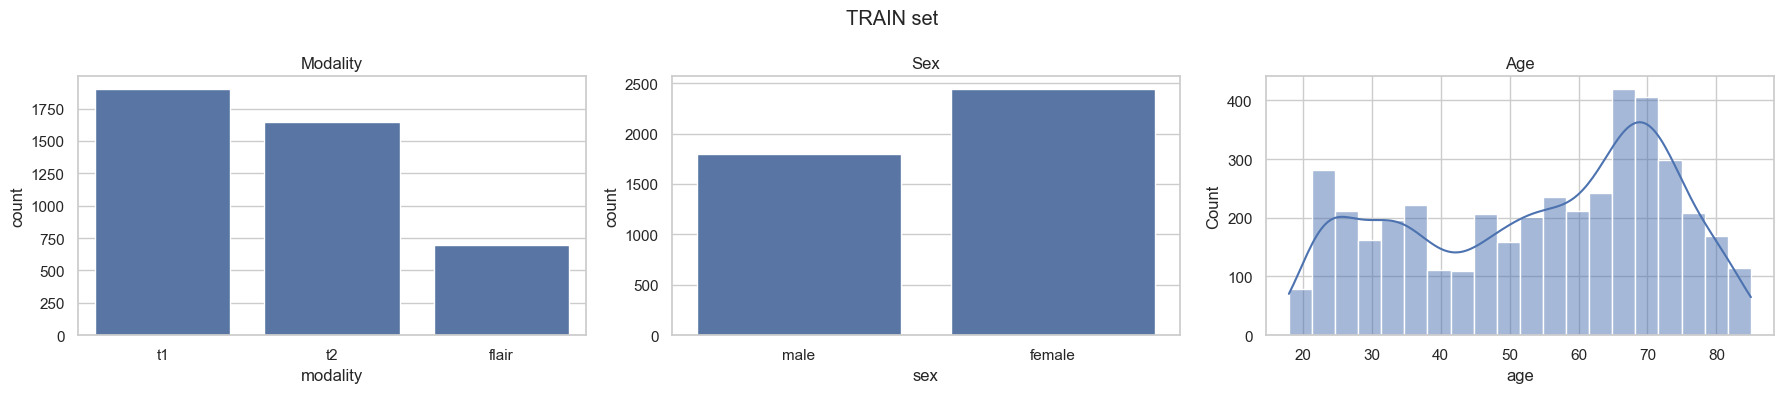

In [42]:
quick_plots(df_train, 'TRAIN set')
train_subset = coverage_report(df_train, 'TRAIN coverage')
train_subset.to_csv(LABEL_DIR / 'train_one_per_combo.csv', index=False)
plot_count_heatmap(df_train, 'TRAIN set')
print(f'Saved train_one_per_combo.csv to {LABEL_DIR.resolve()}')

### Validation Set Analysis


### VAL set – shape: (472, 7)



,subject_id,image_path,sex,age,modality,dataset,sample_weight
5244,sub-OAS30438,brain_age_converted/OASIS/OASIS3/sub-OAS30438_...,female,73.36,t2,oasis3,0.001008
3517,sub-470,brain_age_converted/OpenNeuro/DallasLifeSpan/s...,female,25.00,t1,dallas_lifespan,0.001344
2930,sub-1247,brain_age_converted/OpenNeuro/DallasLifeSpan/s...,female,73.00,t2,dallas_lifespan,0.001008
5236,sub-OAS30430,brain_age_converted/OASIS/OASIS3/sub-OAS30430_...,female,73.22,t2,oasis3,0.001008
4447,sub-ON88762,brain_age_converted/NIMH_RV/sub-ON88762_ses-01...,female,30.00,flair,nimh_rv,0.001344


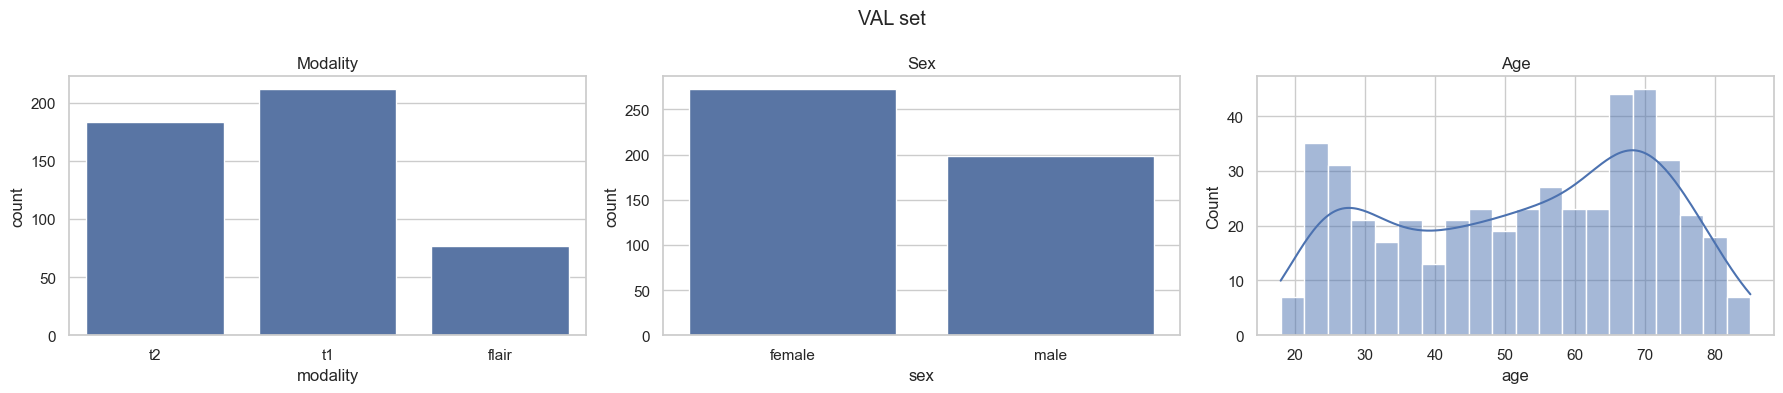

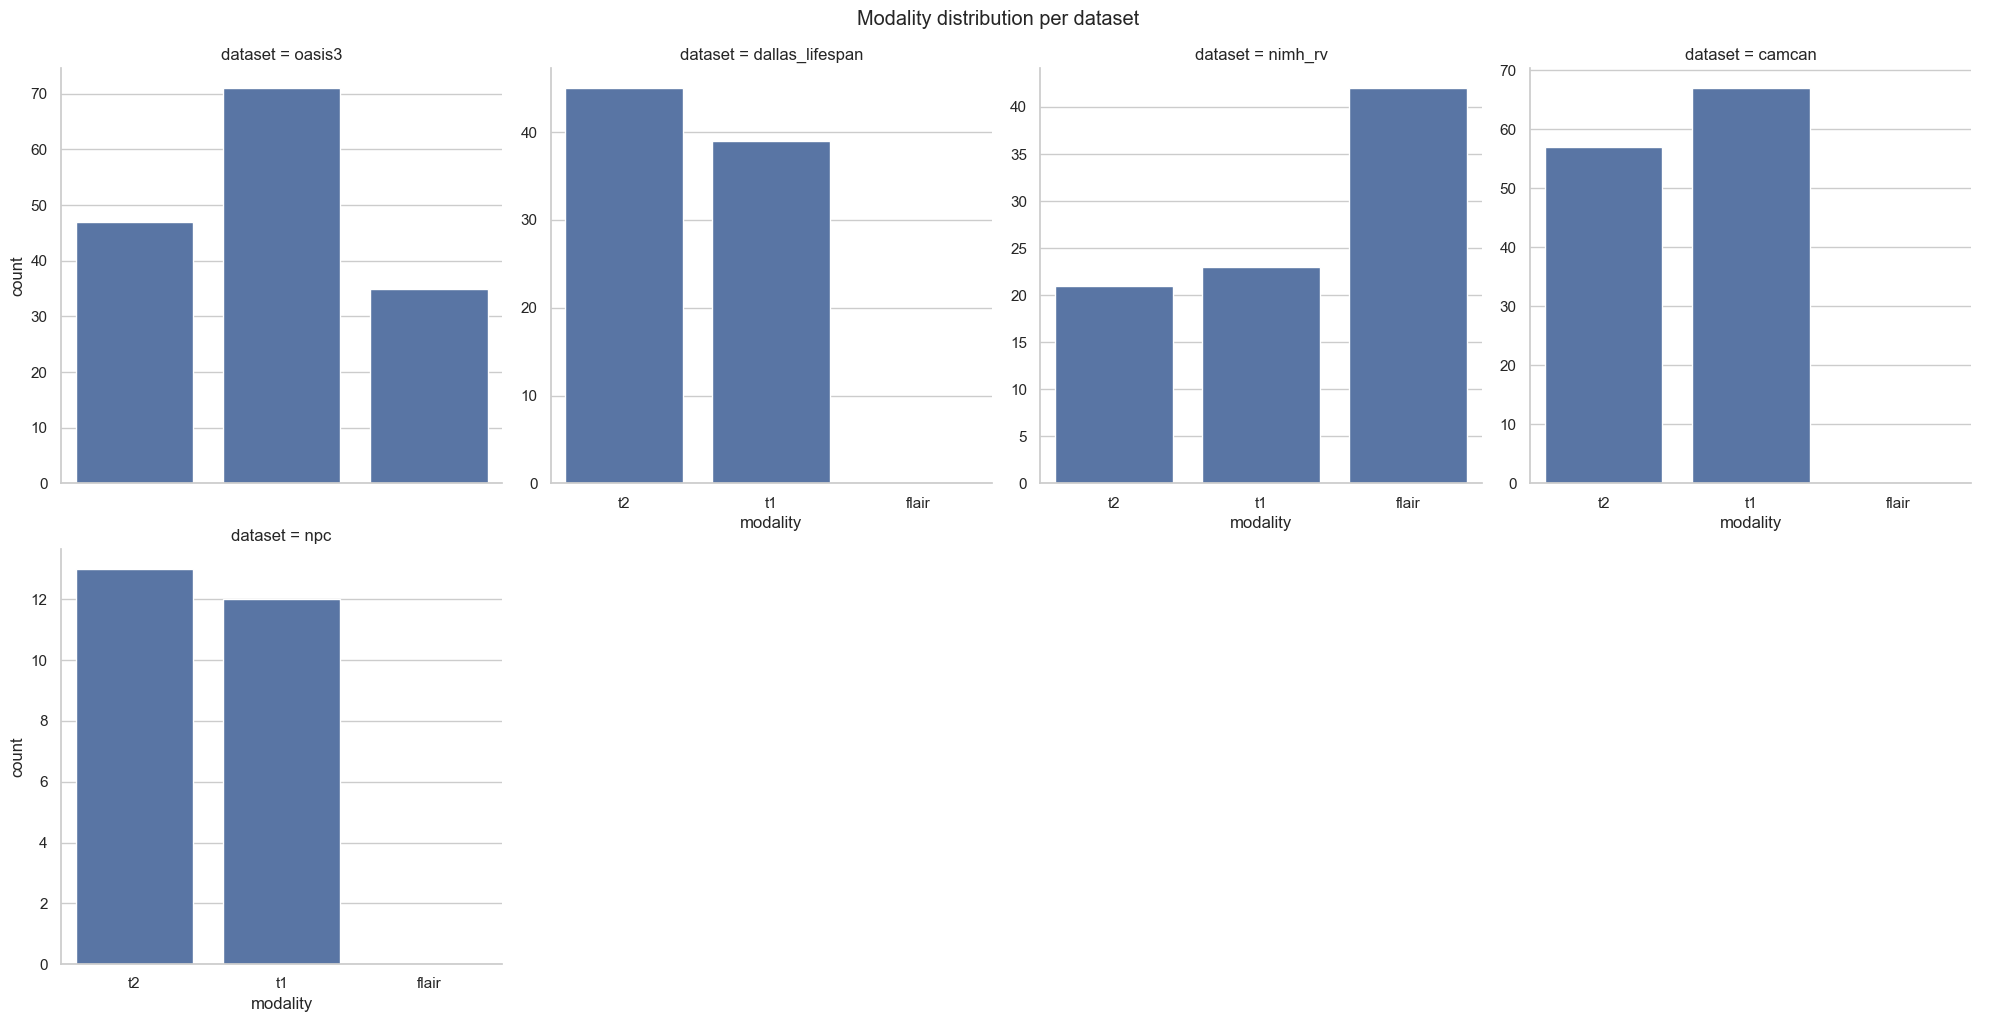

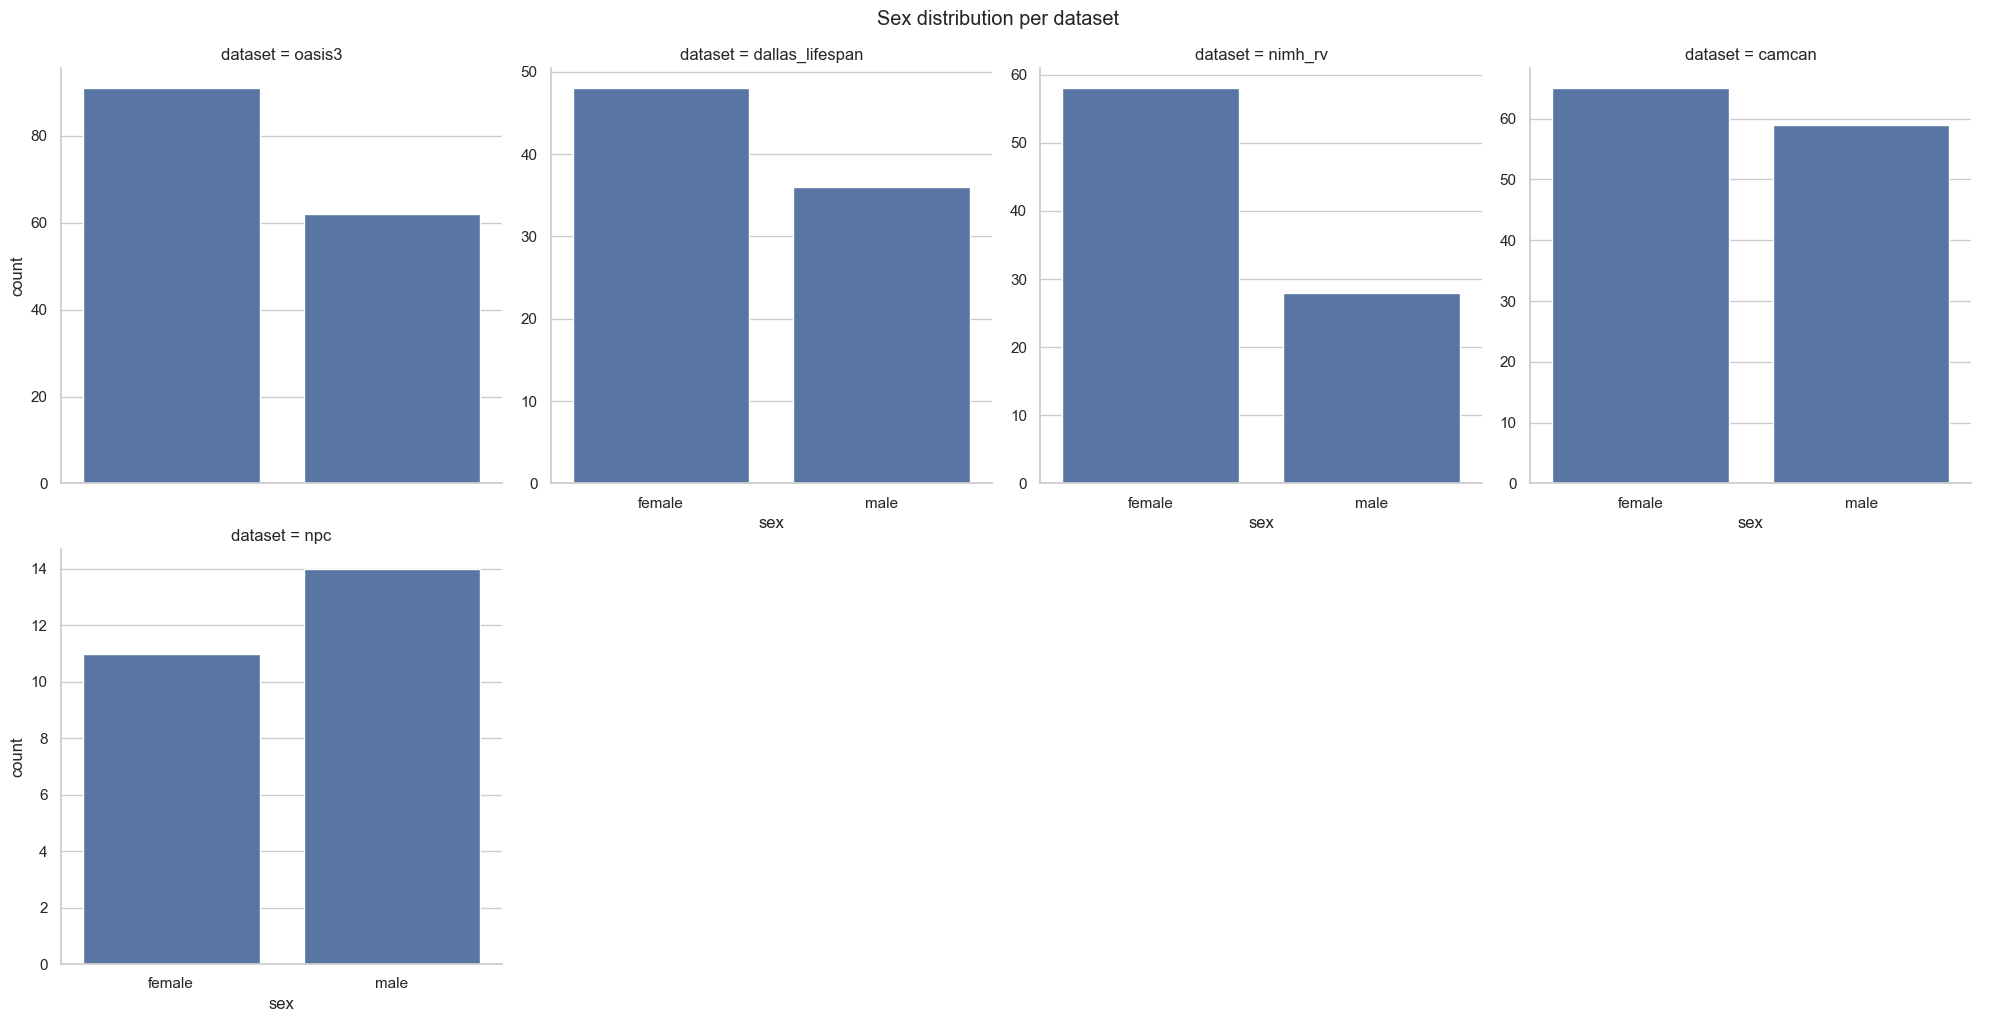

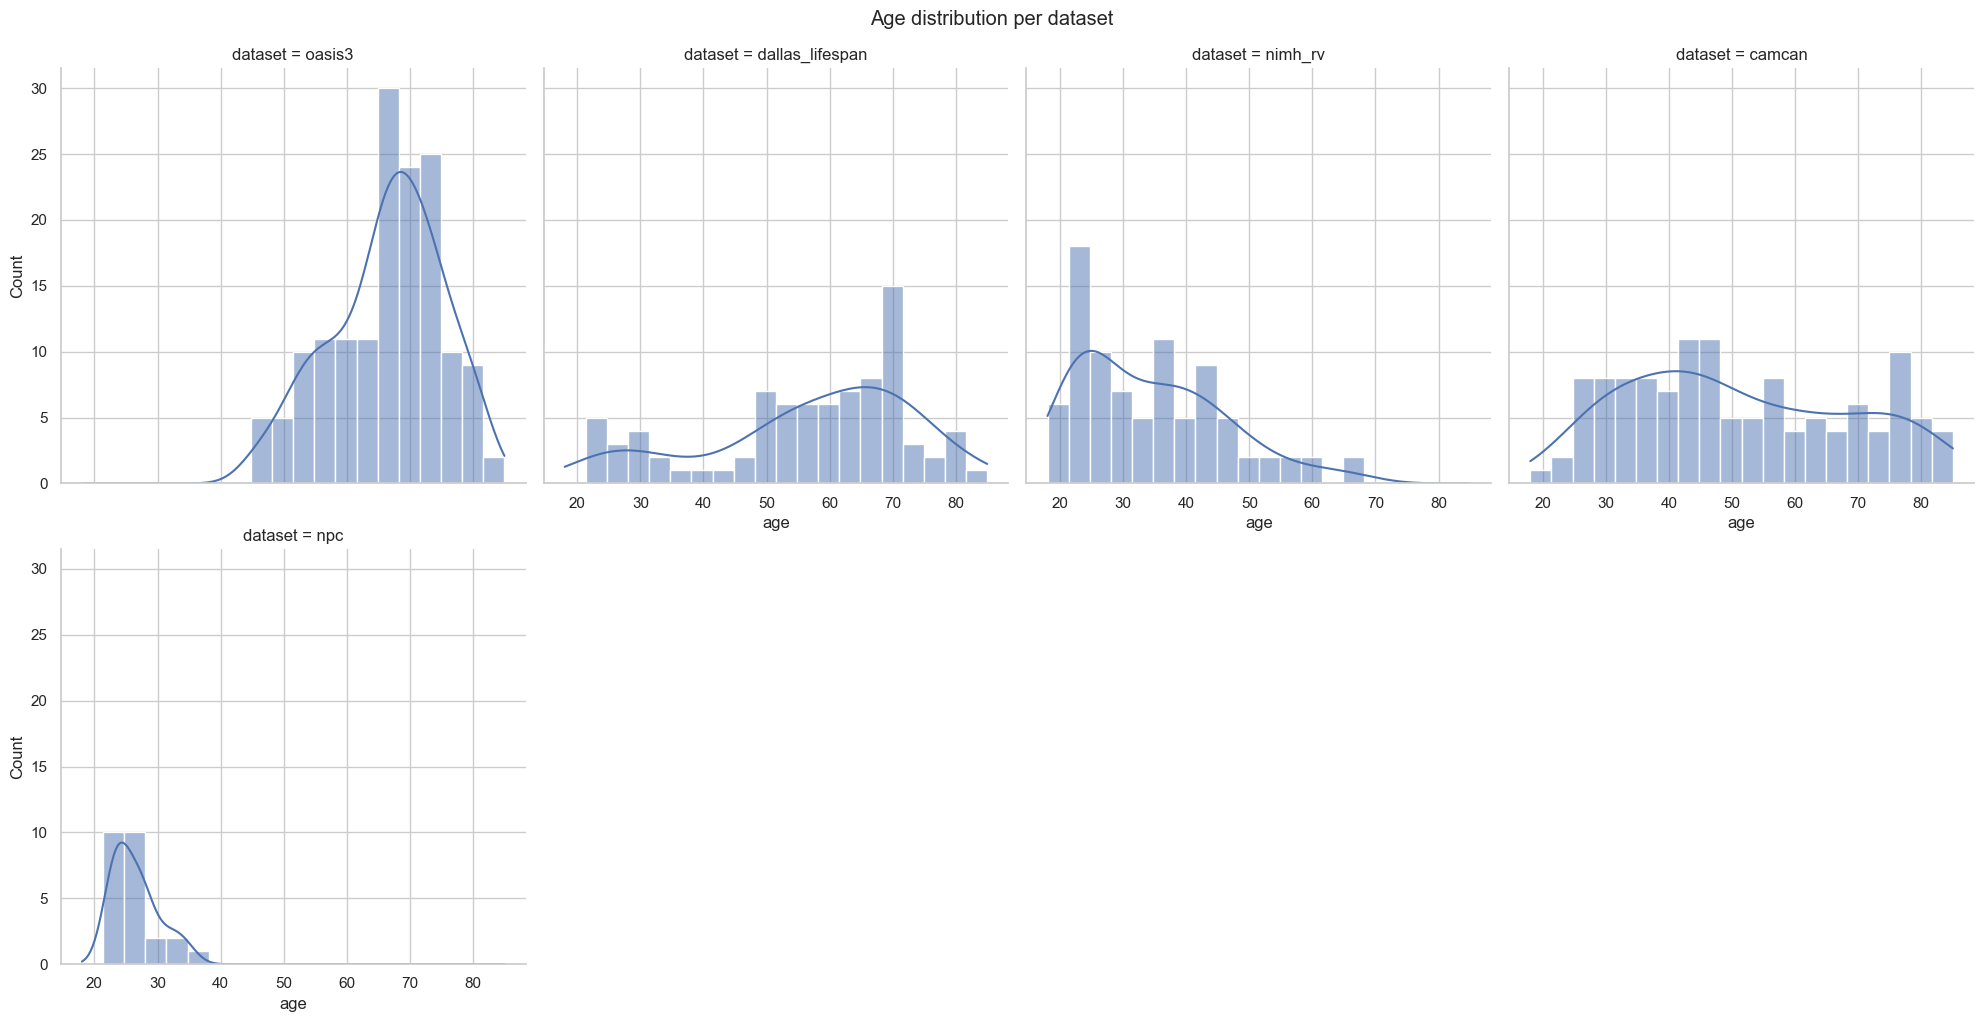

=== VAL coverage ===
Expected combinations : 408
Observed combinations : 248
Missing combinations  : 160



,age,sex,modality
0,18,female,flair
1,18,female,t1
2,18,female,t2
3,18,male,flair
4,18,male,t2
...,...,...,...
155,84,male,flair
156,84,male,t2
157,85,female,flair
158,85,female,t1


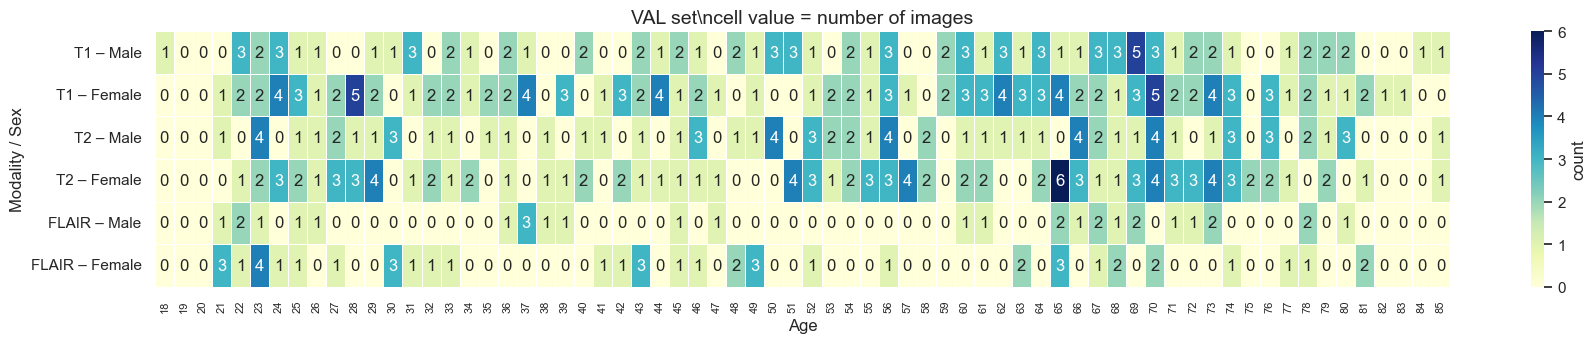

Saved val_one_per_combo.csv to C:\Projects\thesis_project\brain_age_pred\data\labels


In [43]:
if not df_val.empty:
    quick_plots(df_val, 'VAL set')
    val_subset = coverage_report(df_val, 'VAL coverage')
    val_subset.to_csv(LABEL_DIR / 'val_one_per_combo.csv', index=False)
    plot_count_heatmap(df_val, 'VAL set')
    print(f'Saved val_one_per_combo.csv to {LABEL_DIR.resolve()}')
else:
    print('VAL set is empty – no analysis performed.')

### Test Set Analysis


### TEST set – shape: (1483, 7)



,subject_id,image_path,sex,age,modality,dataset,sample_weight
0,IXI002-Guys-0828,brain_age_converted/IXI/IXI002-Guys-0828-T1.ni...,female,35.80,t1,ixi,0.000590
1,IXI002-Guys-0828,brain_age_converted/IXI/IXI002-Guys-0828-T2.ni...,female,35.80,t2,ixi,0.000590
2,IXI012-HH-1211,brain_age_converted/IXI/IXI012-HH-1211-T1.nii.npy,male,38.78,t1,ixi,0.000421
3,IXI012-HH-1211,brain_age_converted/IXI/IXI012-HH-1211-T2.nii.npy,male,38.78,t2,ixi,0.000492
4,IXI013-HH-1212,brain_age_converted/IXI/IXI013-HH-1212-T1.nii.npy,male,46.71,t1,ixi,0.000590


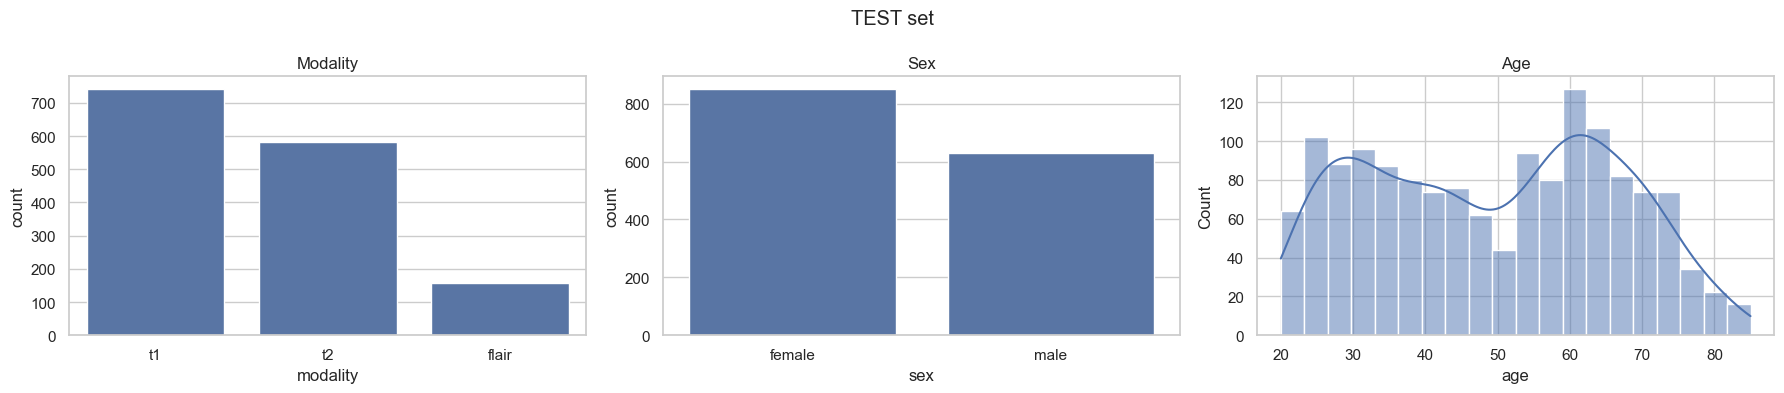

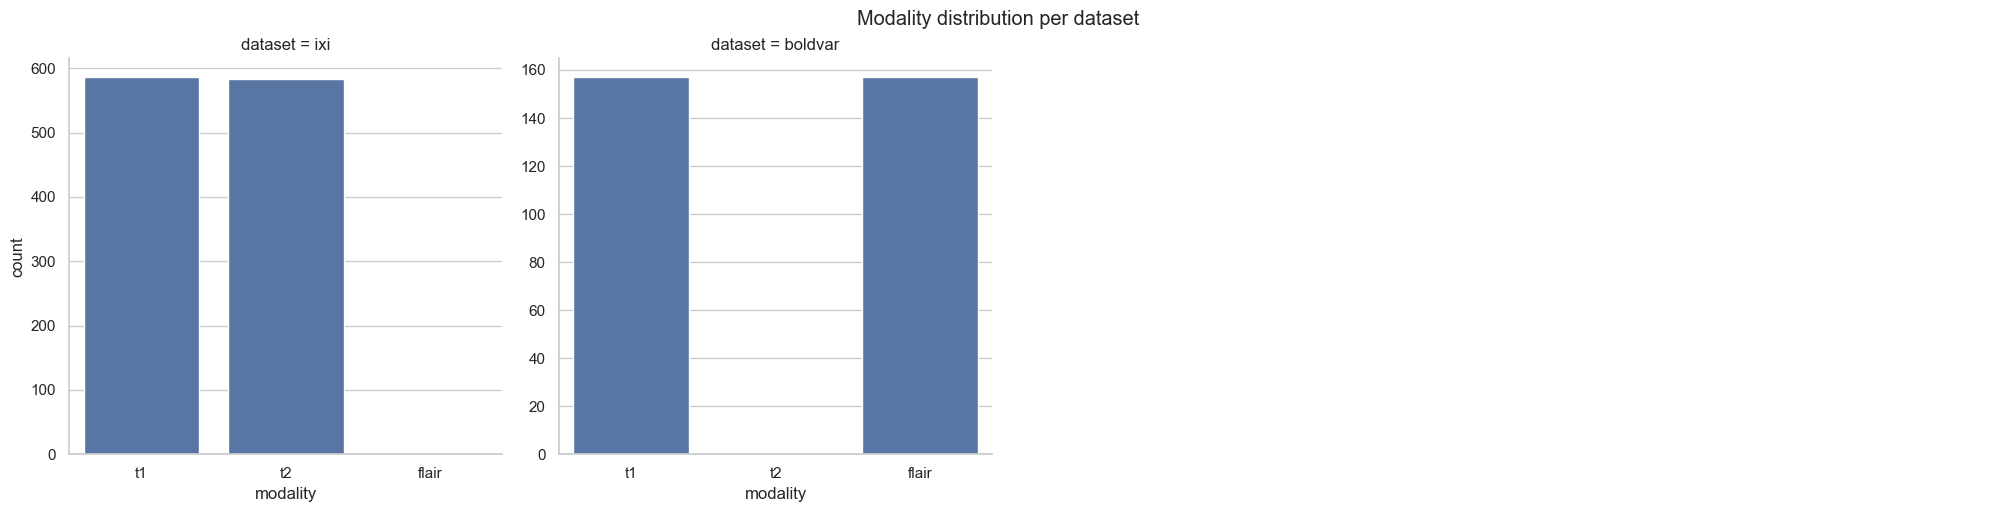

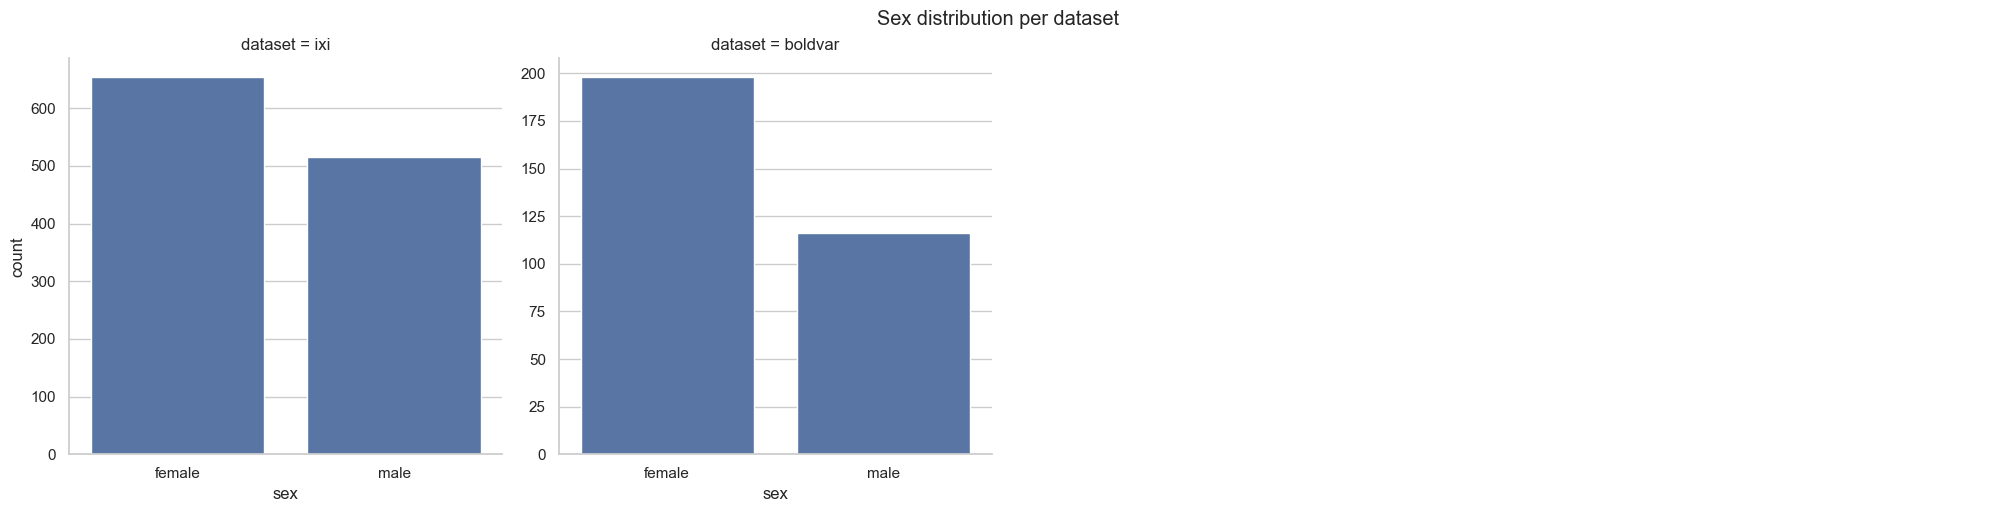

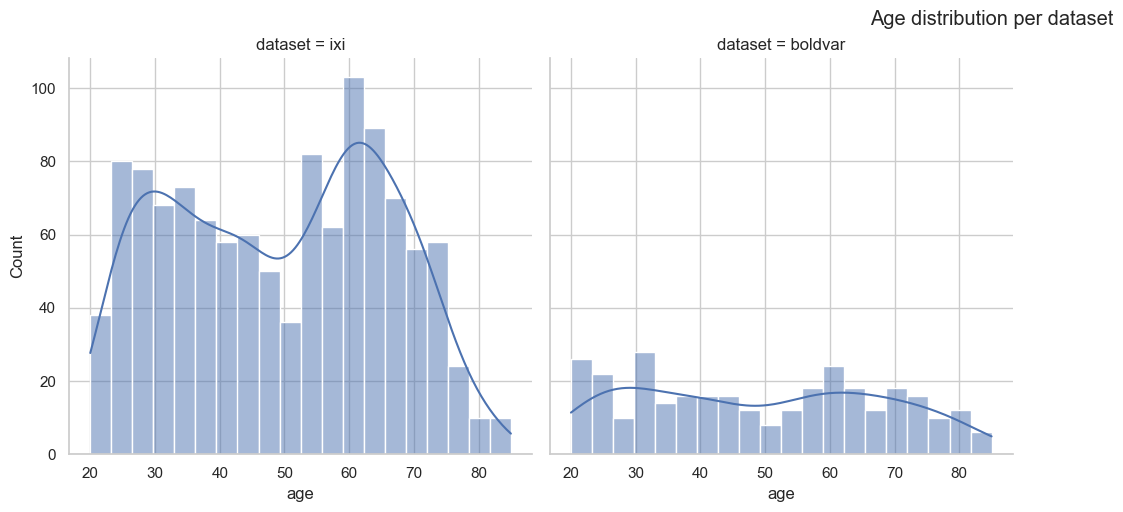

=== TEST coverage ===
Expected combinations : 408
Observed combinations : 339
Missing combinations  : 69



,age,sex,modality
0,18,female,flair
1,18,female,t1
2,18,female,t2
3,18,male,flair
4,18,male,t1
...,...,...,...
64,84,male,t2
65,85,female,t2
66,85,male,flair
67,85,male,t1


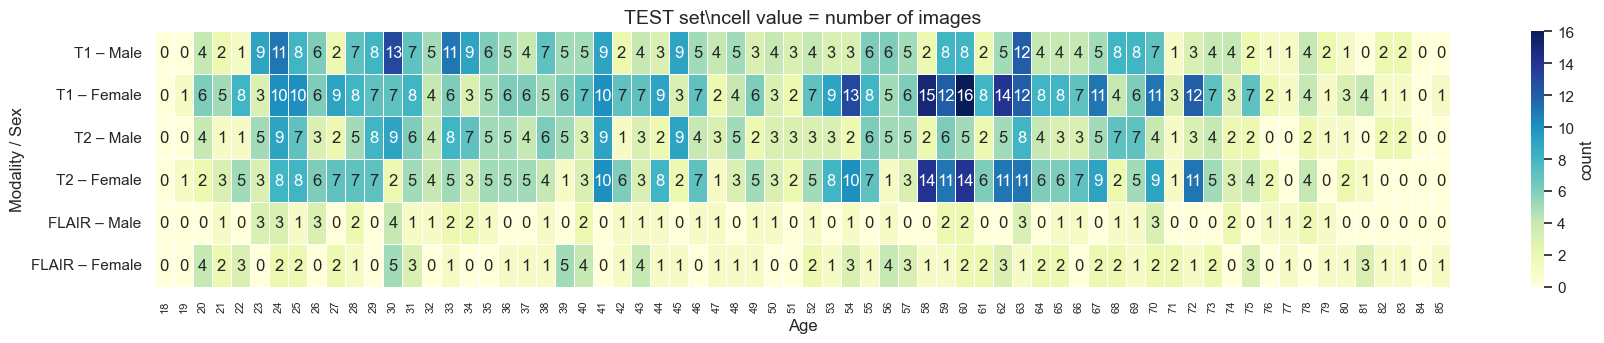

Saved test_one_per_combo.csv to C:\Projects\thesis_project\brain_age_pred\data\labels


In [44]:
quick_plots(df_test, 'TEST set')
test_subset = coverage_report(df_test, 'TEST coverage')
test_subset.to_csv(LABEL_DIR / 'test_one_per_combo.csv', index=False)
plot_count_heatmap(df_test, 'TEST set')
print(f'Saved test_one_per_combo.csv to {LABEL_DIR.resolve()}')

### Full (Train + Val + Test) Dataset Analysis


### FULL dataset (used rows only) – shape: (6199, 6)



,subject_id,image_path,sex,age,modality,dataset
0,IXI002-Guys-0828,brain_age_converted/IXI/IXI002-Guys-0828-T1.ni...,female,35.80,t1,ixi
1,IXI002-Guys-0828,brain_age_converted/IXI/IXI002-Guys-0828-T2.ni...,female,35.80,t2,ixi
2,IXI012-HH-1211,brain_age_converted/IXI/IXI012-HH-1211-T1.nii.npy,male,38.78,t1,ixi
3,IXI012-HH-1211,brain_age_converted/IXI/IXI012-HH-1211-T2.nii.npy,male,38.78,t2,ixi
4,IXI013-HH-1212,brain_age_converted/IXI/IXI013-HH-1212-T1.nii.npy,male,46.71,t1,ixi


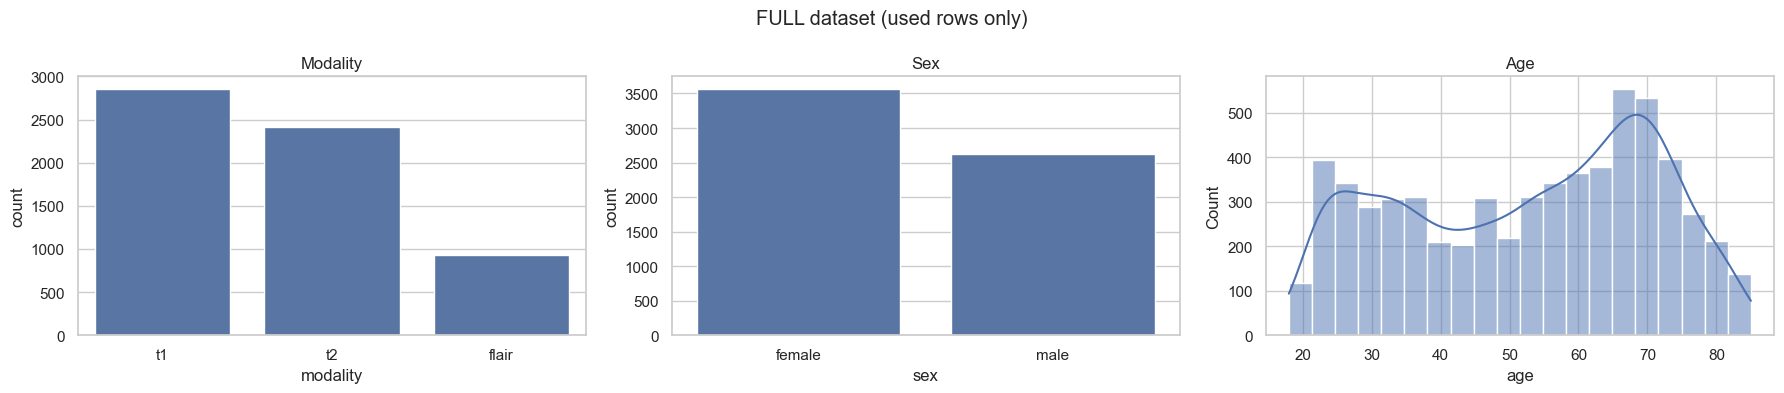

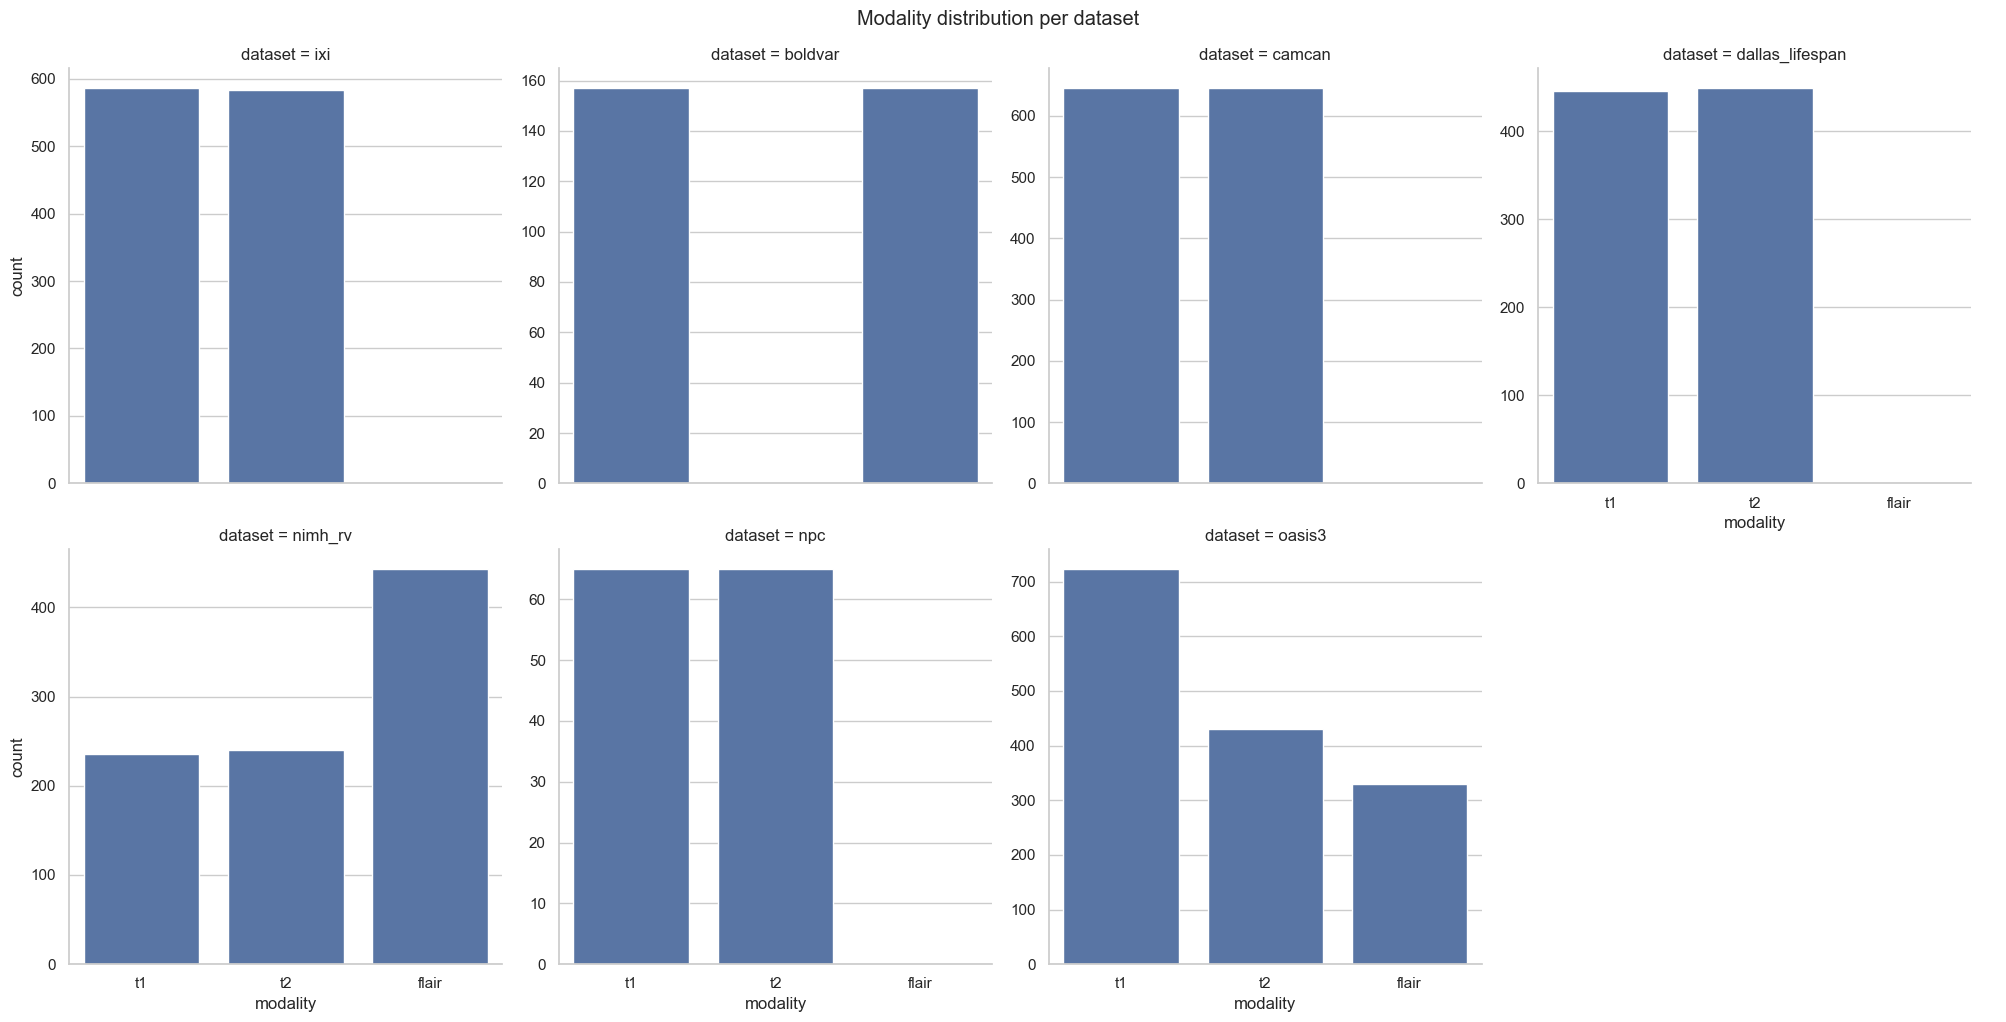

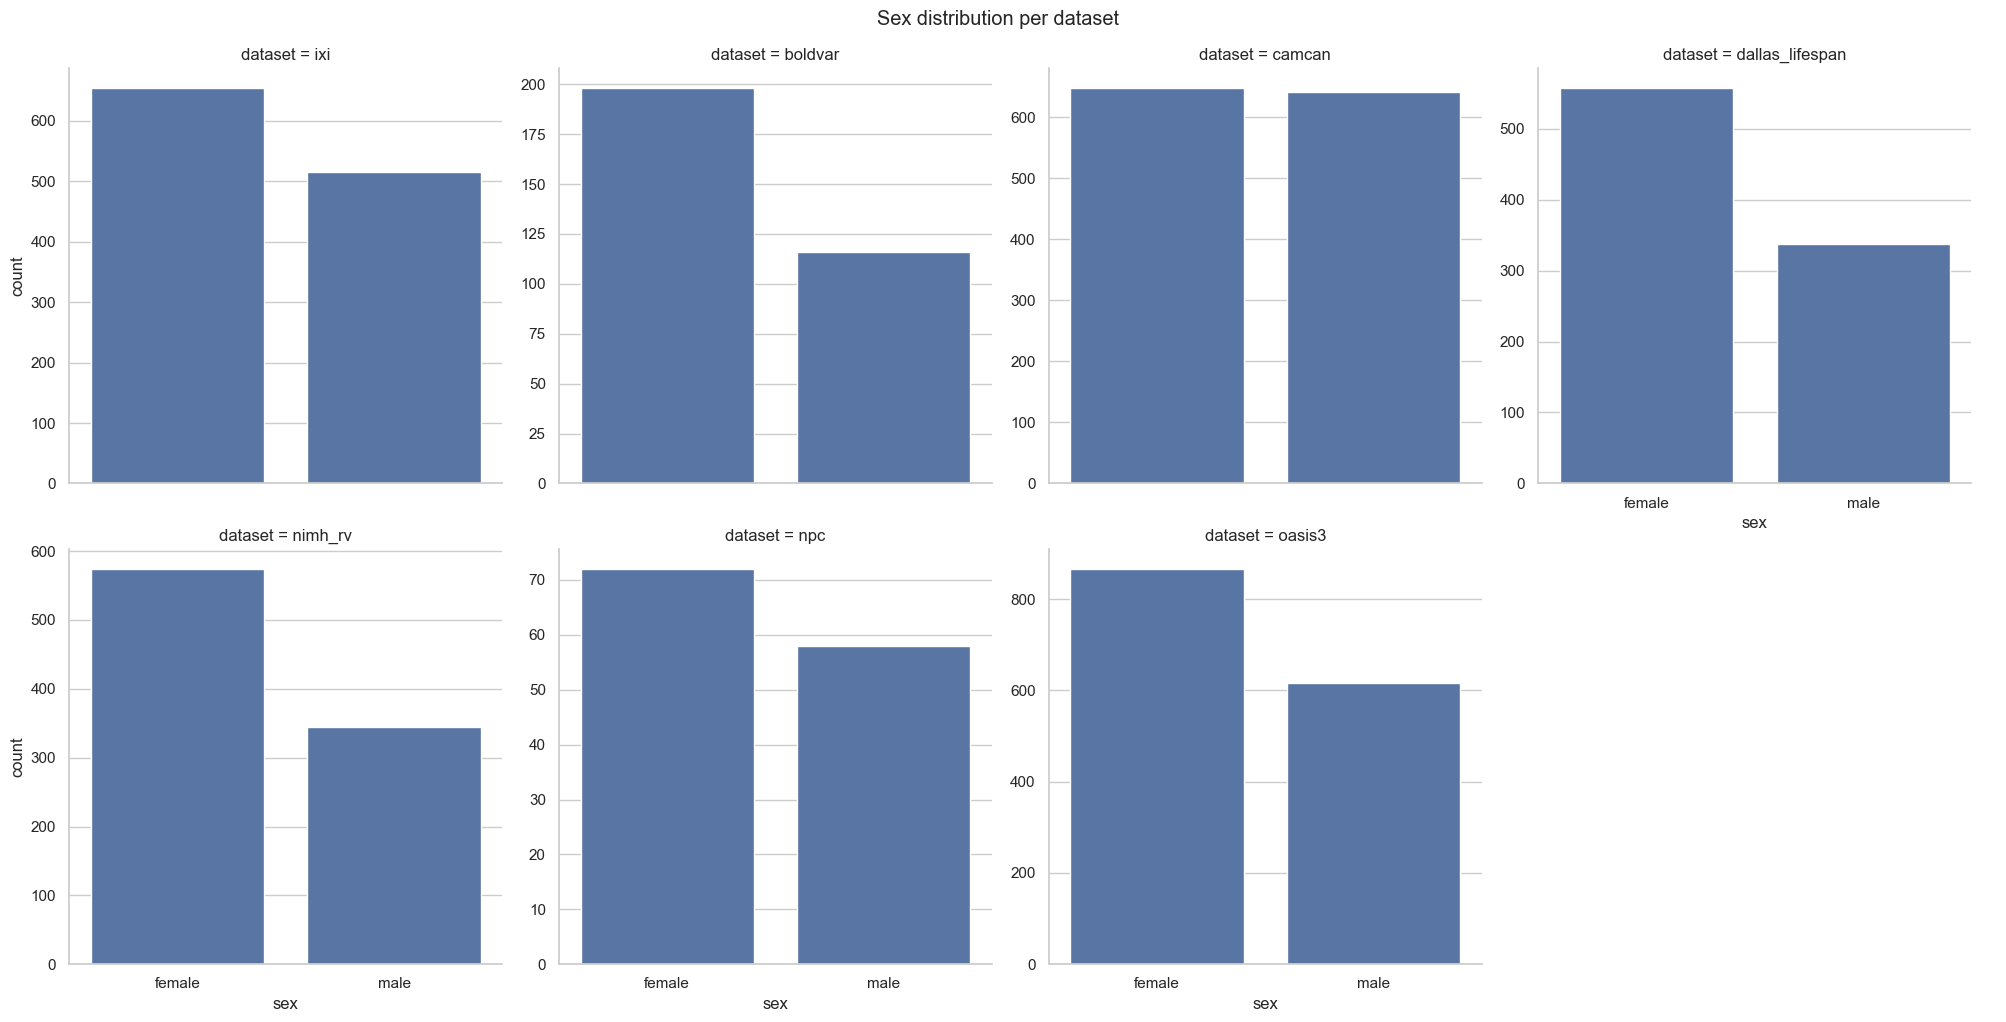

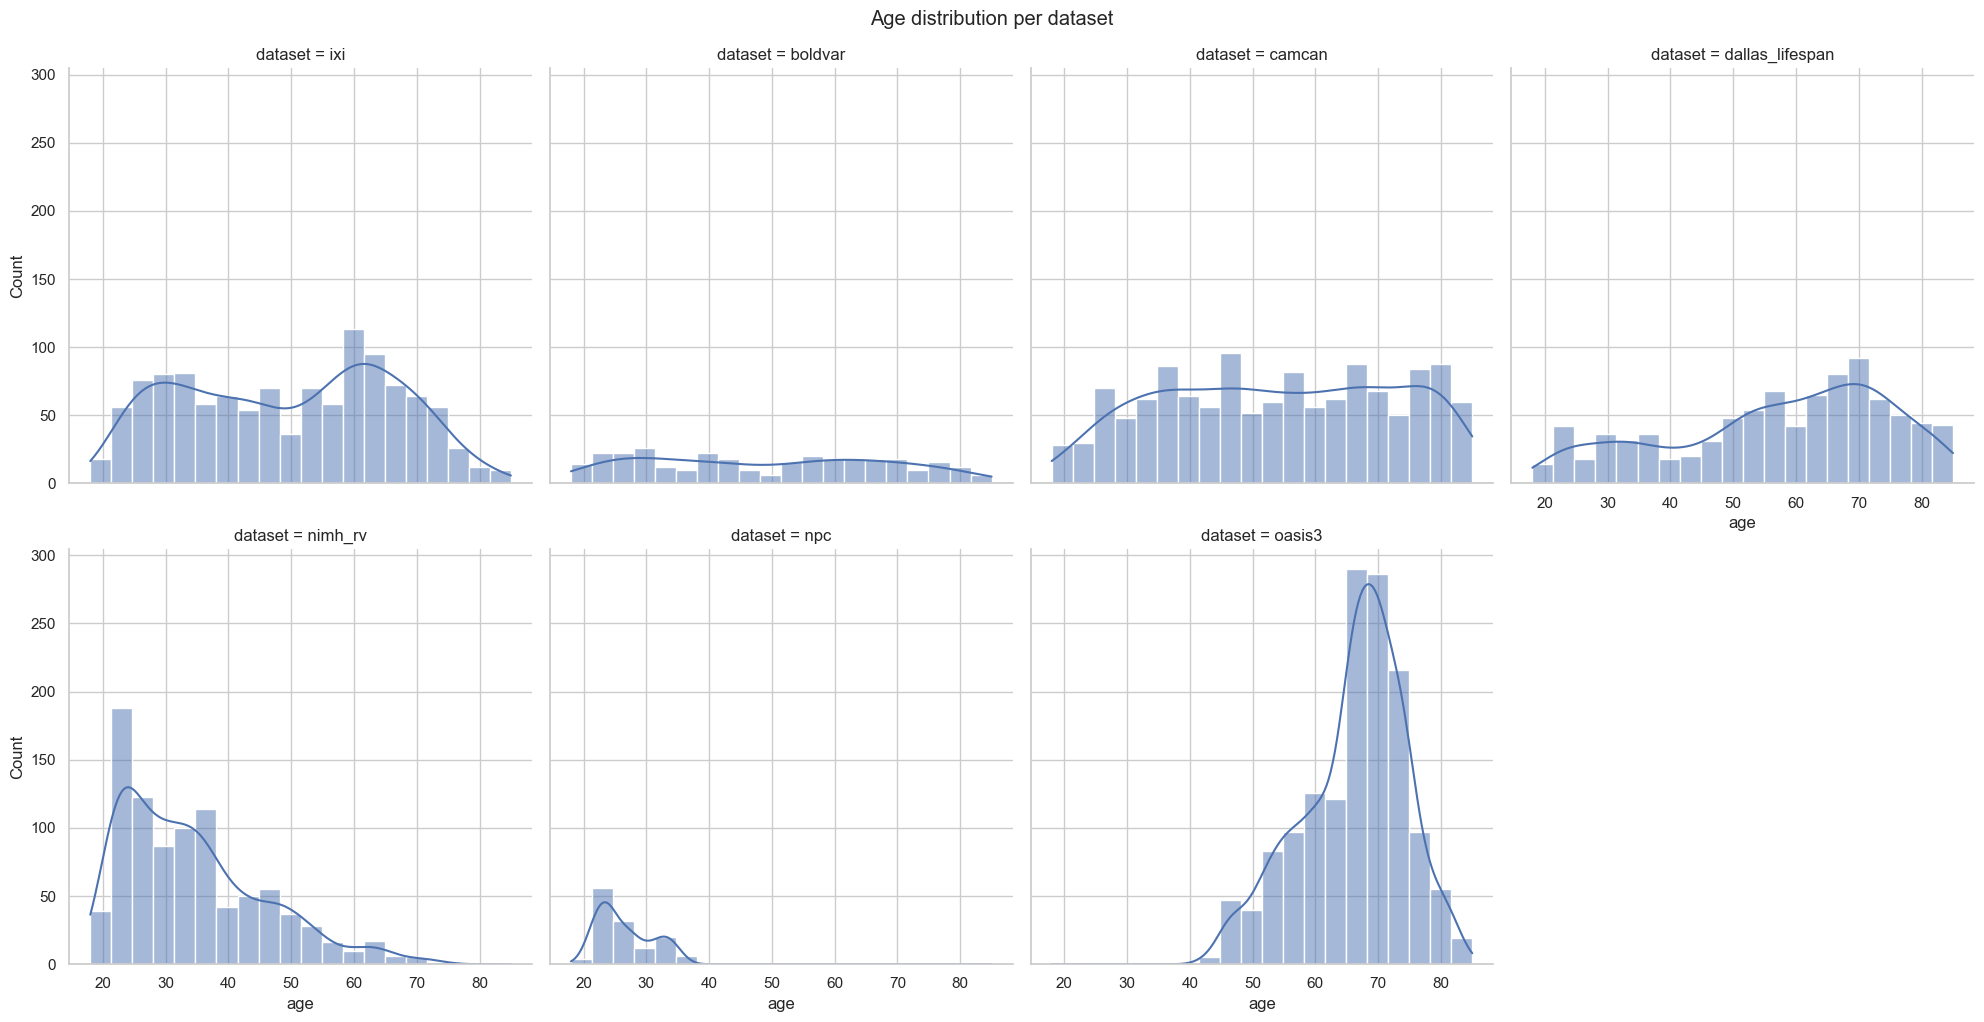

=== FULL coverage ===
Expected combinations : 408
Observed combinations : 399
Missing combinations  : 9



,age,sex,modality
0,18,female,flair
1,18,male,flair
2,19,female,flair
3,41,male,flair
4,82,male,flair
5,83,male,flair
6,84,female,flair
7,84,male,flair
8,85,male,flair


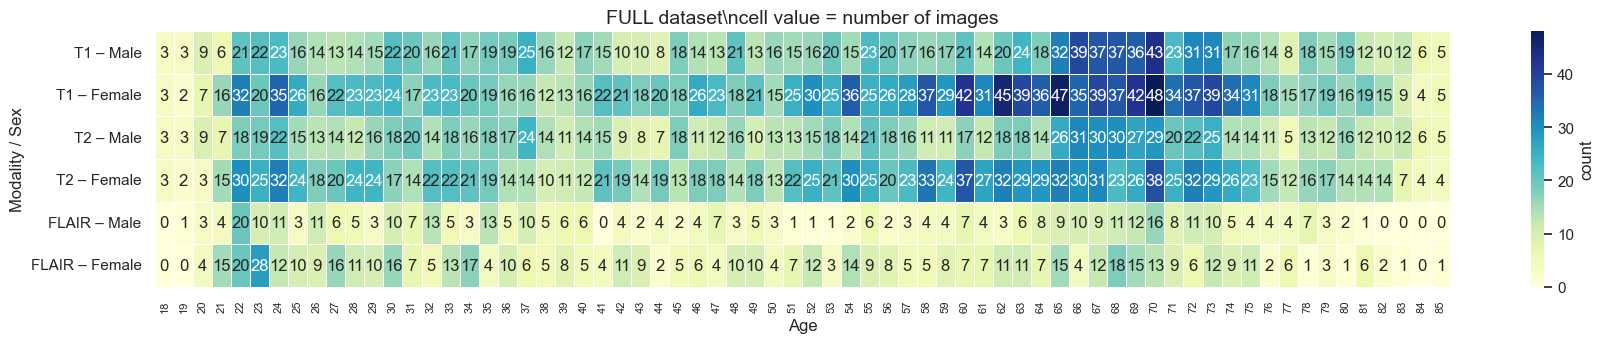

In [45]:
quick_plots(df_all, 'FULL dataset (used rows only)')
_ = coverage_report(df_all, 'FULL coverage')
plot_count_heatmap(df_all, 'FULL dataset')